In [1]:
# ! pip install --upgrade jax jaxlib optax

# Solving satisfiability problem with differential pulse programming on Rydberg atom hardware

## Sovling satisfiability problem with Rydberg atoms 

We start by importing the essential packages and the devices

In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax
from datetime import datetime
from copy import deepcopy

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)


We further import certain device specific constraints such as the maximum allowed Rabi frequencies and others. For convenience, we have used microsecon ($\mu s$) as the unit for `time_max`, and megahertz (MHz) as the unit for the maximum allowed Rabi frequency and detuning.

In [2]:
omega_max = 15800000.0 # rad/second
detuning_max = 125000000.0 # rad/second
time_max = 4e-6 # second
C6 = 862619.79 # MHz μm^6

def angular_SI_to_MHz(angular_SI):
    """Converts a value in rad/s or (rad/s)/s into MHz or MHz/s"""
    return angular_SI / (2 * np.pi) * 1e-6

time_max = time_max * 1e6 
omega_max = angular_SI_to_MHz(omega_max)
detuning_max = angular_SI_to_MHz(detuning_max)

print(f"omega_max    = {omega_max} MHz")
print(f"detuning_max = {detuning_max} MHz")
print(f"time_max     = {time_max} μs")
print(f"C6           = {C6} MHz μm^6")


omega_max    = 2.5146481008519466 MHz
detuning_max = 19.89436788648692 MHz
time_max     = 4.0 μs
C6           = 862619.79 MHz μm^6


## Embedding 3-SAT problem onto Rydberg atoms

Here we embed the 3-SAT problem introduced above onto eight Rydberg atoms. 

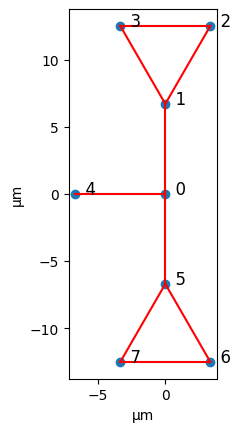

In [3]:
a = 6.7 # μm
R = (C6/omega_max)**(1/6) # μm


coords = [
    [0, 0],
    [0, a],
    [a/2, a + np.sqrt(3)/2 * a],
    [-a/2, a + np.sqrt(3)/2 * a],
    [-a, 0],
    [0, -a],
    [a/2, -a - np.sqrt(3)/2 * a],
    [-a/2, -a - np.sqrt(3)/2 * a],    
]

plt.scatter([x for x, y in coords], [y for x, y in coords])

# Add the labels for the atoms            
for idx, site in enumerate(coords):
    plt.text(site[0], site[1], f"  {idx}", fontsize=12)            

    
# Draw a link for atoms if they are within the blockade radius R
for i in range(len(coords)):
    for j in range(i+1, len(coords)):            
        dist = np.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
        if dist <= R:
            plt.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], 'r')


plt.gca().set_aspect('equal')
plt.xlabel("μm")
plt.ylabel("μm")
plt.show()

Once the atom arrangement is fixed, the interaction term in the Rydberg Hamiltonian is fixed, which can be retrieved as following

In [4]:
H_interaction = qml.pulse.rydberg_interaction(coords, interaction_coeff=C6)

## Driving field

Here we define the driving field, including the amplitude and detuning, for solving the SAT problem. 

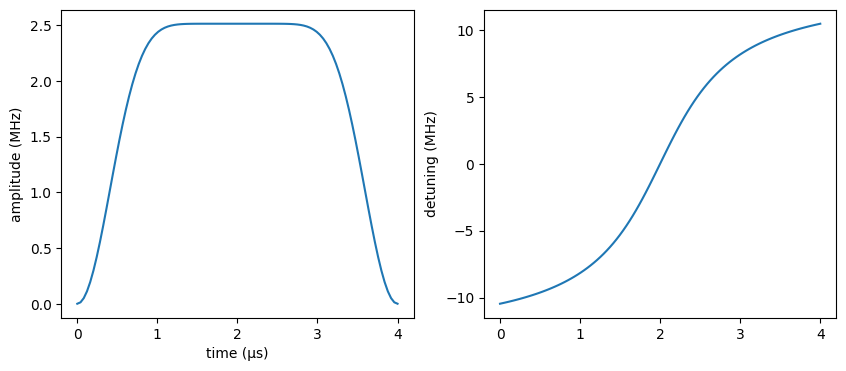

In [5]:
def ryd_amplitude(p, t):
    return p[0] * (1-(1-jnp.sin(jnp.pi * t/time_max)**2)**(p[1]/2))

def ryd_detuning(p, t):
    return p[0] * jnp.arctan(p[1] * (t-time_max/2)) / (jnp.pi/2)

vis_time = np.linspace(0, time_max, 100)

amplitude_para = [omega_max, 10]
detuning_para = [detuning_max * 2/3, 1.45]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_para, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_para, t) for t in vis_time])
axes[1].set_ylabel("detuning (MHz)")
plt.show()

The global drive for the Rydberg Hamiltonian can be defined as following. Throughout this demo, we will fix the phase to be constantly zero. 

In [6]:
global_drive = qml.pulse.rydberg_drive(amplitude=ryd_amplitude,
                                       phase=0,
                                       detuning=ryd_detuning,
                                       wires=range(len(coords)))

## Define the program for solving the SAT problem

We have defined both the atom arrangement and global drive defined for the SAT problem. Let us simulate the evolution of the Rydberg atoms on both the PennyLane and AWS local simulators.

In [7]:
ts = [0, time_max]

def circuit(detuning_para, amplitude_para = amplitude_para, ts = ts):
    qml.evolve(H_interaction + global_drive)([amplitude_para, detuning_para], ts)
    return qml.counts()


default_qubit = qml.device("default.qubit.jax", wires=8, shots=1000)
circuit_qml = qml.QNode(circuit, default_qubit, interface="jax")

rydberg_simulator = qml.device("braket.local.ahs", wires=8)
circuit_ahs = qml.QNode(circuit, rydberg_simulator)

We first run the simulation on the PennyLane simulator

In [8]:
counts_qml = circuit_qml(detuning_para)
counts_qml_sort = sorted(counts_qml.items(), key=lambda x: -x[1])
print(f"PennyLane simulation: ")
print(counts_qml_sort)

PennyLane simulation: 
[('00111011', 207), ('10111011', 142), ('10101011', 70), ('10111010', 69), ('00101011', 64), ('00111010', 53), ('00111001', 50), ('10011011', 45), ('10110011', 44), ('00011011', 40), ('10111001', 32), ('10101010', 28), ('00101010', 23), ('10011010', 16), ('00101001', 13), ('10101001', 12), ('00011010', 11), ('10100011', 11), ('10110001', 11), ('10110010', 10), ('10010010', 8), ('10010011', 8), ('10011001', 8), ('00011001', 5), ('10100010', 4), ('00111110', 3), ('00111101', 2), ('01011011', 2), ('10100001', 2), ('00011101', 1), ('00101101', 1), ('00101110', 1), ('01011001', 1), ('01011010', 1), ('01101010', 1), ('10010001', 1)]


We run the same simulation with the same parameters with the AWS local simulator

In [9]:
counts_ahs = circuit_ahs(detuning_para)
counts_ahs_sort = sorted(counts_ahs.items(), key=lambda x: -x[1])
print(f"AWS local simulation: ")
print(counts_ahs_sort)

AWS local simulation: 
[('00111011', 182), ('10111011', 138), ('10111010', 84), ('00111010', 73), ('10101011', 72), ('00101011', 62), ('10110011', 49), ('00011011', 43), ('10011011', 37), ('00111001', 31), ('10111001', 29), ('10101010', 26), ('00011010', 19), ('10110010', 19), ('10101001', 17), ('00101001', 16), ('00101010', 16), ('10011001', 16), ('10110001', 16), ('10011010', 12), ('10100011', 8), ('10010011', 5), ('10100001', 5), ('10010010', 4), ('00011001', 3), ('00111101', 3), ('01011011', 3), ('10010001', 3), ('10100010', 3), ('00111110', 2), ('01101011', 2), ('00011101', 1), ('01101010', 1)]


We see that both simuator produce the same result. However, the most likely result violate the independent set condition. In the next section, we will use differential programming to find the better driving field that solve the SAT problem while satisfying the IS condition.

## Solving 3-SAT problem with differential programming

We first define the cost function

In [11]:
H_vertex = 0
for i in range(len(coords)):
    H_vertex += -1 * qml.Projector([1], wires=[i])

edges = [
    [1, 2],
    [2, 3],
    [3, 1],
    [1, 0],
    [0, 4],
    [0, 5],
    [5, 6],
    [6, 7],
    [7, 5]
]
for ind_edge, edge in enumerate(edges):
    H_edge = qml.prod(qml.Projector([0], wires=[edge[0]]), qml.Projector([0], wires=[edge[1]]))
    H_edge += qml.prod(qml.Projector([0], wires=[edge[0]]), qml.Projector([1], wires=[edge[1]]))
    H_edge += qml.prod(qml.Projector([1], wires=[edge[0]]), qml.Projector([0], wires=[edge[1]]))
    
    if ind_edge==0:
        H_cost = qml.prod(H_vertex, H_edge)
    else:
        H_cost = qml.prod(H_cost, H_edge)
    
# Option 3: SAT Hamiltonian

Next, we define the circuit that evolve the Rydberg atoms followed by measuring the cost function

In [12]:
dev = qml.device("default.qubit.jax", wires=range(len(coords)))

@qml.qnode(dev, interface="jax")
def circuit_cost(detuning_para, amplitude_para = amplitude_para, ts = ts):
    qml.evolve(H_interaction + global_drive)([amplitude_para, detuning_para], ts)
    return qml.expval(H_cost)

circuit_cost(detuning_para)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/pennylane/measurements/expval.py:56: UserWarning: Prod might not be hermitian.
  warnings.warn(f"{op.name} might not be hermitian.")
/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2003: ComplexWarning: Casting complex values to real discards the imaginary part
  out = np.array(object, dtype=dtype, ndmin=ndmin, copy=False)


Array(-0.21970571, dtype=float64)

For the initial parameter `detuning_para`, the cost function is around `-0.219` whereas for the SAT solutions that satisfy the IS condition, we expect that the cost function reads `-3`. Below, we shall use an optimize to optimize the detuning. We first define the `value_and_grad`, followed by compile it.

In [13]:
theta = deepcopy(detuning_para)

value_and_grad = jax.jit(jax.value_and_grad(circuit_cost))
value_and_grad(theta)

print(theta)

n_epochs = 10

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1e-1)
schedule1 = optax.constant_schedule(5e-1)
schedule = optax.join_schedules([schedule0, schedule1], [10])
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(theta)

energy = np.zeros(n_epochs + 1)
energy[0] = circuit_cost(theta)
gradients = np.zeros(n_epochs)

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
val, grad_circuit = value_and_grad(theta)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")

[13.262911924324612, 1.45]


/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/pennylane/measurements/expval.py:56: UserWarning: Prod might not be hermitian.
  warnings.warn(f"{op.name} might not be hermitian.")
/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2003: ComplexWarning: Casting complex values to real discards the imaginary part
  out = np.array(object, dtype=dtype, ndmin=ndmin, copy=False)


grad and val compilation time: 0:00:03.707196


Finally, we are ready to run the optimization loop

In [14]:
## Optimization loop
for n in range(n_epochs):
    val, grad_circuit = value_and_grad(theta)
    updates, opt_state = optimizer.update(grad_circuit, opt_state)
    theta = optax.apply_updates(theta, updates)

    energy[n + 1] = val
    gradients[n] = np.mean(np.abs(grad_circuit))

    print(n, val)

0 -0.21970570859145303
1 -0.5519697681447742
2 -1.068328644546462
3 -1.6917989375269582
4 -2.274285127033218
5 -2.682993715823812
6 -2.8911470048771464
7 -2.9685200635685187
8 -2.9919326520072116
9 -2.997622211550371


We see that, indeed, the cost function is descented to -3, and the final parameters for the detuning reads

In [15]:
theta

[Array(12.38726739, dtype=float64), Array(0.5554953, dtype=float64)]

We can confirm that, indeed, with the final parameters for the detuning, the counts returned by `circuit_ahs` are all SAT solutions that satisfy the IS condition. 

In [16]:
counts_ahs = circuit_ahs(theta)
counts_ahs_sort = sorted(counts_ahs.items(), key=lambda x: -x[1])
print(f"AWS local simulation: ")
print(counts_ahs_sort)

AWS local simulation: 
[('00101010', 276), ('00101001', 210), ('00011010', 201), ('00011001', 128), ('10100010', 50), ('10010010', 44), ('10100001', 42), ('10010001', 35), ('00101100', 5), ('00011100', 4), ('01001010', 3), ('01001001', 2)]


We can compare the detuning before and after the optimization

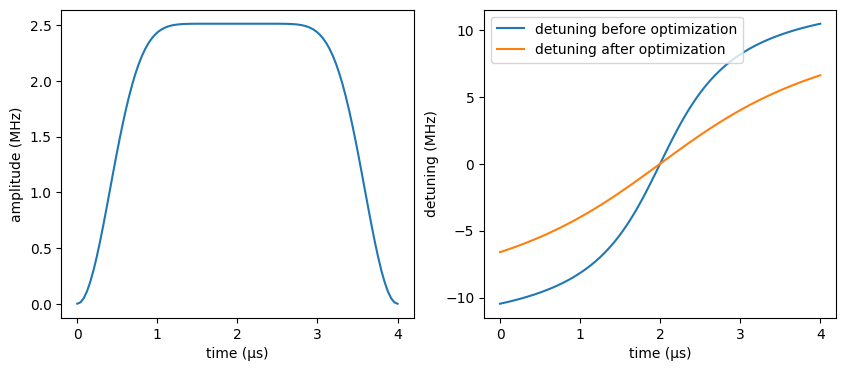

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_para, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_para, t) for t in vis_time], label="detuning before optimization")
axes[1].plot(vis_time, [ryd_detuning(theta, t) for t in vis_time], label="detuning after optimization")
axes[1].set_ylabel("detuning (MHz)")
axes[1].set_xlabel("time (μs)")
axes[1].legend()
plt.show()


To confirm that the optimized detuning indeed produce higher probability of getting the SAT solution, we run the programs on the hardware and compare their results. We first import QuEra's Aquila device followed by defining the corresponding circuit.

In [19]:
aquila = qml.device(
    "braket.aws.ahs",
    device_arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
    wires=len(coords),
)

@qml.qnode(aquila)
def circuit_cost_aquila(detuning_para, amplitude_para = amplitude_para, ts = ts):
    qml.evolve(H_interaction + global_drive)([amplitude_para, detuning_para], ts)
    return qml.expval(H_cost)

In [21]:
# counts_aquila_before = circuit_cost_aquila(detuning_para)

In [22]:
# counts_aquila_after = circuit_cost_aquila(theta)

In summary, we show how to solve the SAT problem with Rydberg atoms using differential programming. 